In [ ]:
## run anchor for gru

In [17]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
from transformer.utils import *
from datasets.dataset_loader import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [20]:
model = load_model('gru' , 'transformer/gru_sentiment.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [21]:
# 1 = pad 2=sos 3 = eos
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [22]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>100):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

# Anchor Part

In [23]:
nlp = spacy.load('en_core_web_sm')

In [24]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [12]:
train, train_labels = [' '.join(example.text) for example in ds_train], [example.label for example in ds_train]
test, test_labels = [' '.join(example.text) for example in ds_train], [explainer.class_names.index(example.label) for example in ds_train]

In [13]:
anchor_examples = [example for example in train if len(example) < 70 and len(example)>20]

In [21]:
pickle.dump( test, open( "results/transformer_test.pickle", "wb" ))
pickle.dump( test_labels, open( "results/transformer_test_labels.pickle", "wb" ))
pickle.dump( anchor_examples, open( "results/transformer_anchor_examples.pickle", "wb" ))

In [ ]:
my_utils = TextUtils(anchor_examples, counter_test, explainer, predict_sentences, "results/transformer_exps.pickle")
explanations = my_utils.compute_explanations(list(range(len(anchor_examples))))

In [ ]:
pickle.dump( explanations, open( "results/transformer_exps_list.pickle", "wb" ))

# Loading Results

In [26]:
test = np.array(pickle.load( open( "results/transformer_test.pickle", "rb" )))
test_labels = np.array(pickle.load( open( "results/transformer_test_labels.pickle", "rb" )))
explanations  = pickle.load(open( "results/transformer_exps_list.pickle", "rb" ))
anchor_examples = pickle.load( open( "results/transformer_anchor_examples.pickle", "rb" ))

In [ ]:
explanations= []
exps_file  = open( "results/transformer_exps.pickle", "rb" )
num_exps = 2000
for _ in range(num_exps):
    explanations.append(pickle.load(exps_file))
exps_file.close()
explanations = TextUtils.remove_duplicates(explanations)

In [16]:
explanations = [ExtendedExplanation(exp, anchor_examples, test, test_labels, predict_sentences, explainer) for exp in explanations if len(exp.fit_examples) > 0]
pickle.dump( explanations, open( "results/transformer_extended_exps.pickle", "wb" ))

In [52]:
explanations = pickle.load(open( "results/transformer_extended_exps.pickle", "rb" ))

In [11]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 10] 
explanations.sort(key=lambda exp: exp.test_precision)

In [12]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>=4]
best = filtered[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    
    print('Anchor test REAL precision: %.2f' % exp.real_precision)
   

------------------------
Prediction: negative
Anchor: loses
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.92
Anchor test coverage: 0.01
Anchor test REAL precision: 0.83
------------------------
Prediction: positive
Anchor: cool AND movie
Precision: 0.98
Coverage: 0.00
Anchor test precision: 0.87
Anchor test coverage: 0.02
Anchor test REAL precision: 0.80
------------------------
Prediction: negative
Anchor: white AND black
Precision: 0.98
Coverage: 1.00
Anchor test precision: 0.73
Anchor test coverage: 0.02
Anchor test REAL precision: 0.67
------------------------
Prediction: negative
Anchor: usually
Precision: 0.97
Coverage: 0.00
Anchor test precision: 0.73
Anchor test coverage: 0.03
Anchor test REAL precision: 0.67
------------------------
Prediction: negative
Anchor: barely
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.71
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
Prediction: negative
Anchor: considered
Precision: 1.00
Co

In [13]:
exps = explanations[len(explanations)//2:]
exps = [exp for exp in exps if len(exp.fit_examples)>10]
#trained model has the opposite label
real_precisions = [exp.real_precision for exp in exps]
test_precisions = [exp.test_precision for exp in exps]

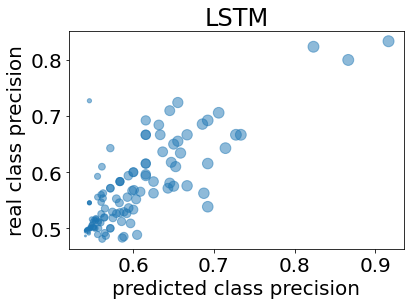

In [14]:
plt.scatter(test_precisions, real_precisions, s = range(len(exps)), alpha = 0.5)
plt.xlabel('predicted class precision')
plt.ylabel('real class precision')
plt.title('LSTM')
plt.savefig("results/transformer.png")

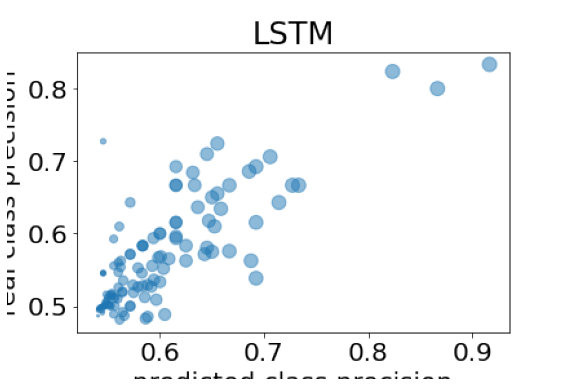

In [15]:
img = plt.imread("results/transformer.png")
plt.figure(figsize = (10,10))
plt.axis('off')
_ = plt.imshow(img)